In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

In [3]:
jax.__version__

'0.4.16'

## When differentiating with respect to the first parameter is not enough

In [4]:
def dist(order, x, y):
  return jnp.power(jnp.sum(jnp.abs(x-y)**order), 1.0/order)

In [5]:
dist_d_x = jax.grad(dist, argnums=1)

In [6]:
dist_d_xy = jax.grad(dist, argnums=(1,2))

In [7]:
dist_d_x(1, jnp.array([1.0,1.0,1.0]), jnp.array([2.0,2.0,2.0]))


Array([-1., -1., -1.], dtype=float32)

In [8]:
dist_d_xy(1, jnp.array([1.0,1.0,1.0]), jnp.array([2.0,2.0,2.0]))

(Array([-1., -1., -1.], dtype=float32), Array([1., 1., 1.], dtype=float32))

## Differentiating with respect to multiple parameters

In [9]:
x = np.linspace(0, 10*np.pi, num=1000)
e = np.random.normal(scale=10.0, size=x.size)
y = 65.0 + 1.8*x + 40*np.cos(x) + e

xt = jnp.array(x)
yt = jnp.array(y)
learning_rate = 1e-2

In [10]:
model_parameters = {
    'w': jnp.array([1.]),
    'b': jnp.array([1.])
    }

def model(param_dict, x):
    w, b = param_dict['w'], param_dict['b']
    return w * x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction-y)**2)

grads_fn = jax.grad(loss_fn)
grads = grads_fn(model_parameters, xt, yt)


In [11]:
print(grads)

{'b': Array([-153.29868], dtype=float32), 'w': Array([-2533.0576], dtype=float32)}


## Returning auxiliary data from a function

In [12]:
model_parameters = jnp.array([1., 1.])

def model(theta, x):
    w, b = theta
    return w * x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction-y)**2), prediction

grads_fn = jax.grad(loss_fn, has_aux=True)
grads, preds  = grads_fn(model_parameters, xt, yt)
model_parameters -= learning_rate * grads


In [13]:
model_parameters

Array([26.330576 ,  2.5329866], dtype=float32)

In [14]:
grads

Array([-2533.0576 ,  -153.29868], dtype=float32)

In [15]:
preds.shape

(1000,)

## Obtaining both gradient and value of the function

In [16]:
model_parameters = jnp.array([1., 1.])

def model(theta, x):
    w, b = theta
    return w * x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction-y)**2), prediction

grads_fn = jax.value_and_grad(loss_fn, has_aux=True)
(loss, preds), grads  = grads_fn(model_parameters, xt, yt)
model_parameters -= learning_rate * grads


In [17]:
loss

Array(6793.313, dtype=float32)

In [18]:
preds.shape

(1000,)

In [19]:
grads

Array([-2533.0576 ,  -153.29868], dtype=float32)

# Stopping gradient flow

In [20]:
def f(x, y):
  return x**2 + jax.lax.stop_gradient(y**2)


In [21]:
def f(x, y):
  return x**2 + y**2

In [22]:
jax.grad(f, argnums=(0,1))(1.0, 1.0)

(Array(2., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True))

# Higher-order derivatives

In [23]:
def f(x):
    return x**4 + 12*x + 1/x

f_d1 = jax.grad(f)
f_d2 = jax.grad(f_d1)
f_d3 = jax.grad(f_d2)

x = 11.0

print(f_d1(x))
print(f_d2(x))
print(f_d3(x))


5335.9917
1452.0015
263.9996


In [24]:
f_d3 = jax.grad(jax.grad(jax.grad(f)))

print(f_d3(x))

263.9996


Displaying several derivatives:

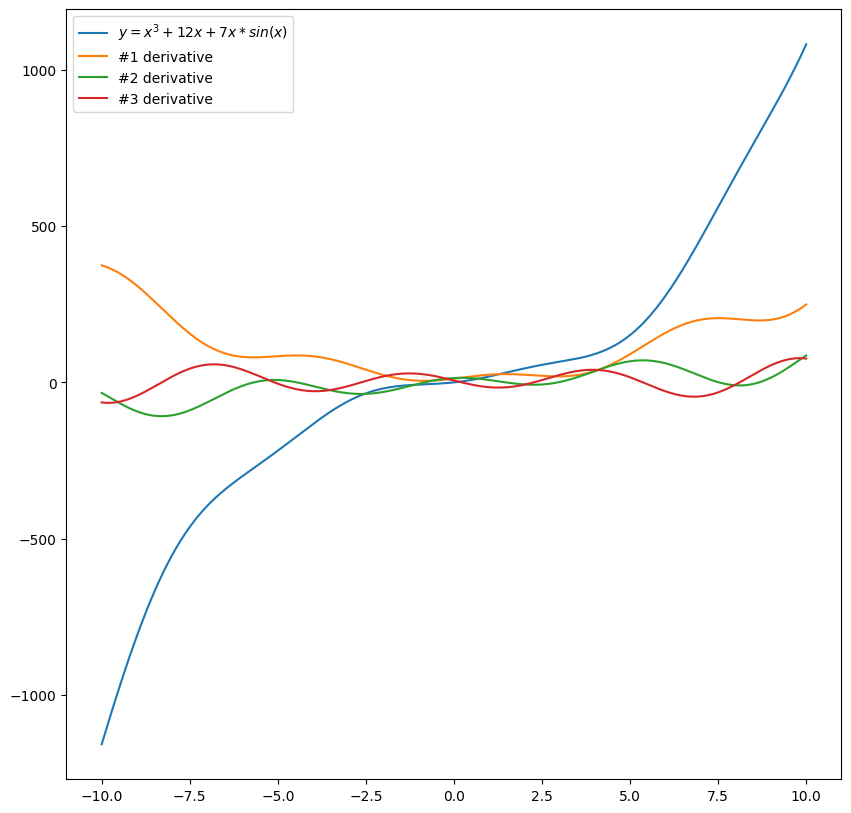

In [25]:
def f(x):
    return x**3 + 12*x + 7*x*jnp.sin(x)

x = np.linspace(-10, 10, num=500)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, f(x), label = r"$y = x^3 + 12x + 7x*sin(x)$")

df = f
for d in range(1,4):
  df = jax.grad(df)
  #ax.plot(x, (df)(x), label=f'#{d} derivative')
  ax.plot(x, jax.vmap(df)(x), label=f'#{d} derivative')
  ax.legend()

# Jacobians

In [26]:
def f(x):
  return [
      x[0]**2 + x[1]**2 - x[1]*x[2],
      x[0]**2 - x[1]**2 + 3*x[0]*x[2]
  ]

In [27]:
print(jax.jacrev(f)(jnp.array([3.0, 4.0, 5.0])))

[Array([ 6.,  3., -4.], dtype=float32), Array([21., -8.,  9.], dtype=float32)]


In [29]:
print(jax.jacfwd(f)(jnp.array([3.0, 4.0, 5.0])))

[Array([ 6.,  3., -4.], dtype=float32), Array([21., -8.,  9.], dtype=float32)]


In [30]:
%timeit -n 100 jax.jacrev(f)(jnp.array([3.0, 4.0, 5.0]))

33.4 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%timeit -n 100 jax.jacfwd(f)(jnp.array([3.0, 4.0, 5.0]))

21.6 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Hessian

In [32]:
def f(x):
  return x[0]**2 - x[1]**2 + 3*x[0]*x[2]

In [33]:
jax.hessian(f)(jnp.array([3.0, 4.0, 5.0]))

Array([[ 2.,  0.,  3.],
       [ 0., -2.,  0.],
       [ 3.,  0.,  0.]], dtype=float32)

In [34]:
jax.jacfwd(jax.grad(f))(jnp.array([3.0, 4.0, 5.0]))

Array([[ 2.,  0.,  3.],
       [ 0., -2.,  0.],
       [ 3.,  0.,  0.]], dtype=float32)

In [36]:
jax.jacfwd(jax.jacrev(f))(jnp.array([3.0, 4.0, 5.0]))

Array([[ 2.,  0.,  3.],
       [ 0., -2.,  0.],
       [ 3.,  0.,  0.]], dtype=float32)

# JVP

Code for checking manual computations

In [37]:
def f(x1,x2):
  return x1*x2 + jnp.sin(x1*x2)

In [38]:
x = (7.0, 2.0)

In [39]:
f(*x)

Array(14.990607, dtype=float32, weak_type=True)

In [42]:
jax.grad(f)(*x)

Array(2.2734745, dtype=float32, weak_type=True)

In [43]:
jax.grad(f, argnums=(0,1))(*x)

(Array(2.2734745, dtype=float32, weak_type=True),
 Array(7.9571605, dtype=float32, weak_type=True))

JVP example

In [44]:
def f2(x):
  return [
      x[0]**2 + x[1]**2 - x[1]*x[2],
      x[0]**2 - x[1]**2 + 3*x[0]*x[2]
  ]

x = jnp.array([3.0, 4.0, 5.0])
v = jnp.array([1.0, 1.0, 1.0])

In [45]:
p,t = jax.jvp(f2, x, v)

TypeError: ignored

In [46]:
p,t = jax.jvp(f2, (x,), (v,))

In [47]:
p

[Array(5., dtype=float32), Array(38., dtype=float32)]

In [48]:
t

[Array(5., dtype=float32), Array(22., dtype=float32)]

In [49]:
p,t = jax.jvp(f2, (x,), (jnp.array([1.0, 0.0, 0.0]),))
t

[Array(6., dtype=float32), Array(21., dtype=float32)]

In [50]:
p,t = jax.jvp(f2, (x,), (jnp.array([0.0, 1.0, 0.0]),))
t

[Array(3., dtype=float32), Array(-8., dtype=float32)]

In [51]:
p,t = jax.jvp(f2, (x,), (jnp.array([0.0, 0.0, 1.0]),))
t

[Array(-4., dtype=float32), Array(9., dtype=float32)]

Checking manual computations with jvp()

In [52]:
def f(x1,x2):
  return x1*x2 + jnp.sin(x1*x2)

x = (7.0, 2.0)

p,t = jax.jvp(f, x, (1.0, 0.0))

In [53]:
p

Array(14.990607, dtype=float32, weak_type=True)

In [54]:
t

Array(2.2734745, dtype=float32, weak_type=True)

# VJP

In [55]:
def f(x1,x2):
  return x1*x2 + jnp.sin(x1*x2)

x = (7.0, 2.0)

p,vjp_func = jax.vjp(f, *x)

In [56]:
p

Array(14.990607, dtype=float32, weak_type=True)

In [57]:
vjp_func(1.0)

(Array(2.2734745, dtype=float32, weak_type=True),
 Array(7.9571605, dtype=float32, weak_type=True))

In [58]:
vjp_func(2.0)

(Array(4.546949, dtype=float32, weak_type=True),
 Array(15.914321, dtype=float32, weak_type=True))

More complicated function

In [59]:
def f2(x):
  return [
      x[0]**2 + x[1]**2 - x[1]*x[2],
      x[0]**2 - x[1]**2 + 3*x[0]*x[2]
  ]

x = jnp.array([3.0, 4.0, 5.0])

In [60]:
p,vjp_func = jax.vjp(f2, x)

In [61]:
p

[Array(5., dtype=float32), Array(38., dtype=float32)]

Restoring rows of the Jacobian

In [62]:
vjp_func([1.0, 0.0])

(Array([ 6.,  3., -4.], dtype=float32),)

In [63]:
vjp_func([0.0, 1.0])

(Array([21., -8.,  9.], dtype=float32),)